<a href="https://colab.research.google.com/github/LCaravaggio/DeepLearning_ITBA/blob/main/RL/01_Monte_Carlo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo y Cálculo de Varianza

https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance

https://en.wikipedia.org/wiki/Monte_Carlo_method

# Importamos librerías y bajamos modeles pre-entrenados

In [1]:
# instalación de libreías y bajada de modelos
# pip install gym
# pip install moviepy
! pip install tensorboardX
! pip install box2d-py
! wget https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/cartpole-trained.hdf5
! wget https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/lunar-lander-trained.hdf5
! wget https://raw.githubusercontent.com/deeplearning-itba/REINFORCE-Algorithm/master/REINFORCE_helper.py

--2021-11-11 18:52:32--  https://github.com/deeplearning-itba/REINFORCE-Algorithm/raw/master/cartpole-trained.hdf5
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/deeplearning-itba/REINFORCE-Algorithm/master/cartpole-trained.hdf5 [following]
--2021-11-11 18:52:33--  https://raw.githubusercontent.com/deeplearning-itba/REINFORCE-Algorithm/master/cartpole-trained.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33032 (32K) [application/octet-stream]
Saving to: ‘cartpole-trained.hdf5.2’

cartpole-trained.hd 100%[===================>]  32.26K  --.-KB/s    in 0.002s  

2021-11-11 18:52:33 (14.1 MB

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from seaborn import distplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Entornos de OpenAI

Vamos a usar dos entornos: CartPole-v1 y LunarLander-v2.

Instanción entorno y realizar las pruebas que se piden:

In [3]:
# Instanciamos los entornos.
env_cp = gym.make("CartPole-v1")
env_ll = gym.make("LunarLander-v2")

Usar las propiedades del entorno action_space y observation_space para responder las siguientes preguntas: 

¿Cúal es la dimensión del espacio de acción del CartPole?

¿Cúal es la dimensión del espacio de acción del LunarLander?

¿Cúal es la dimensión del espacio de observación del CartPole?

¿Cúal es la dimensión del espacio de observación del LunarLander?

In [4]:
# Ejecutar la siguiente celda y ver que devuelve
env_ll.seed()
env_ll.reset()

# ¿Que devuelve? ¿Siempre es el mismo resultado?

array([-0.00578499,  1.4049823 , -0.5859736 , -0.26391897,  0.00671016,
        0.13273181,  0.        ,  0.        ], dtype=float32)

In [5]:
# Ejecutar la siguiente celda y ver que devuelve
env_ll.seed(42)
env_ll.reset()

# ¿Que devuelve? ¿Siempre es el mismo resultado?

array([-0.00499964,  1.4194578 , -0.506422  ,  0.37943238,  0.00580009,
        0.11471219,  0.        ,  0.        ], dtype=float32)

In [6]:
# Para el CartPole
# Observation: 
#     Type: Box(4)
#     Num	Observation                 Min         Max
#     0	Cart Position             -4.8            4.8
#     1	Cart Velocity             -Inf            Inf
#     2	Pole Angle                 -24 deg        24 deg
#     3	Pole Velocity At Tip      -Inf            Inf
    
# Actions:
#     Type: Discrete(2)
#     Num	Action
#     0	Push cart to the left
#     1	Push cart to the right

In [7]:
# Para el LunarLander
# Coordinates are the first two numbers in state vector.
# Actions:
# Nop, fire left engine, main engine, right engine

# Implementar Monte carlo

Implementar función run_episode_with_random_policy con una politica aleatoria con distribución uniforme

In [8]:
def run_episode_with_random_policy(env, seed=42):
    done = False
    env.seed(seed)
    obs = env.reset()
    rewards = []
    observations = []
    actions = []
    while not done:
        action = env.action_space.sample()
        obs_, reward, done, _ = env.step(action)
        rewards.append(reward)
        observations.append(obs)
        actions.append(action)
        obs = obs_
    return np.array(observations), np.array(actions), np.array(rewards)

In [9]:
observations, actions, rewards = run_episode_with_random_policy(env_ll)

Implementar funcion monte_carlo_with_random_policy

In [10]:
def monte_carlo_with_random_policy(env, seed=42, N=500):
  returns = []
  running_variance = RunningVariance()
  run_var = []
  run_mean = []
  for i in range(N):
    print(f'\rEpisodio: {i}', end='')
    observations, actions, rewards = run_episode_with_random_policy(env_ll, seed=42)
    return_ = np.sum(rewards)
    running_variance.add(return_)
    run_var.append(running_variance.get_variance())
    run_mean.append(running_variance.get_mean())
    returns.append(return_)
  print()
  returns = np.array(returns)
  run_var = np.array(run_var)
  run_mean = np.array(run_mean)
  return run_mean, run_var, returns

In [11]:
class RunningVariance:
    # Keeps a running estimate of variance

    def __init__(self):
        self.m_k = None
        self.s_k = None
        self.k = None

    def add(self, x):
        if not self.m_k:
            self.m_k = x
            self.s_k = 0
            self.k = 0
        else:
            old_mk = self.m_k
            self.k += 1
            self.m_k += (x - self.m_k) / self.k
            self.s_k += (x - old_mk) * (x - self.m_k)

    def get_variance(self, epsilon=1e-12):
        return self.s_k / (self.k - 1 + epsilon) + epsilon
    
    def get_mean(self):
        return self.m_k

In [12]:
# Cambiar de entornos env_cp y env_ll
run_mean, run_var, returns = monte_carlo_with_random_policy(env_cp, N=2000)

Episodio: 1999


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


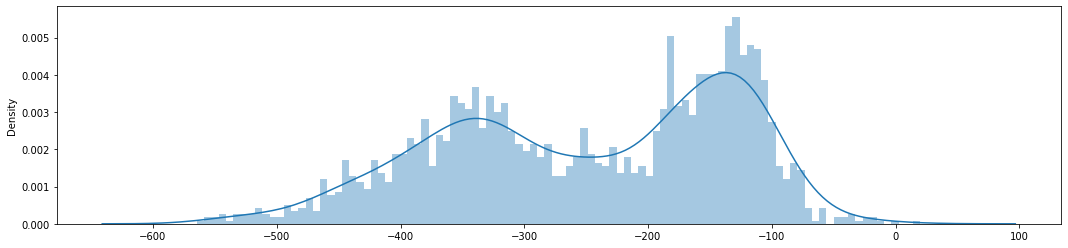

In [13]:
plt.figure(figsize=(18,4))
distplot(returns, bins=100)

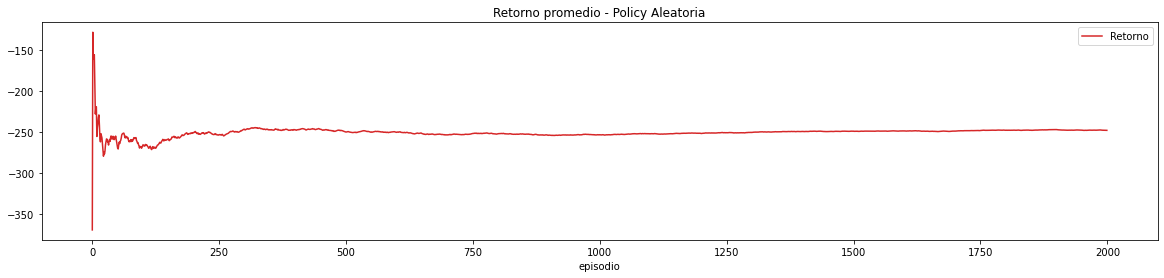

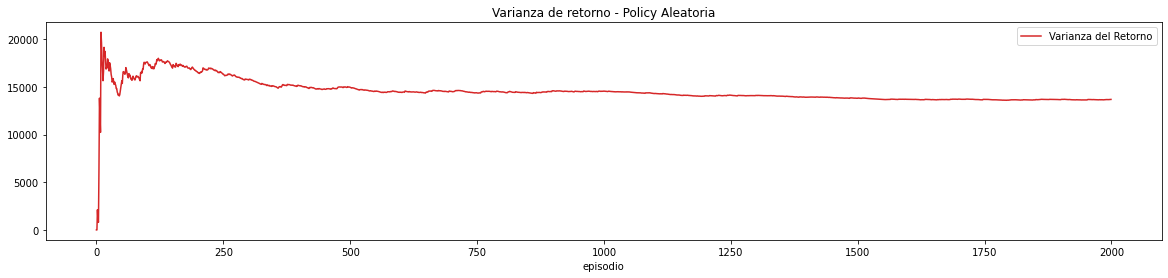

In [14]:
plt.figure(figsize=(20,4))
plt.plot(run_mean, c='C3', label='Retorno')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()
plt.figure(figsize=(20,4))
plt.plot(run_var, c='C3', label='Varianza del Retorno')
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()

# Conclusiones

El retorno cambia con cada episodio como es de esperar. Es una variable aleatoria -> Tiene una media y una varianza (alta)

Su distribución depende del entorno. 

¿Si la politica hubiera sido deterministica, dado cualquier entorno, el retorno sería aleatorio? ¿Que pasa si sabemos que en el lunarlander tenemos viento?



# Preguntas:

Al fijar una semilla, el estado inicial $s_0$ estado es siempre el mismo. Cual es el estado inicial de cada entorno con una semilla de 42?

In [15]:
env_ll.seed(42)
s_0 = env_ll.reset()
print(s_0)

[-0.00499964  1.4194578  -0.506422    0.37943238  0.00580009  0.11471219
  0.          0.        ]


Teniendo en cuanto lo anterior ¿El retorno estimado es la $V(s_0)$ o la $Q(s_0, a_0)$?

In [16]:
def Q_with_random_policy(env, a_0, seed=42):
    done = False
    env.seed(seed)
    env.reset()
    rewards = []
    _, reward, done, _ = env.step(a_0)
    rewards.append(reward)
    while not done:
        action = np.random.randint(env.action_space.n)
        _, reward, done, _ = env.step(action)
        rewards.append(reward)
    return sum(rewards)

In [17]:
Q_with_random_policy(env_cp, 0)

14.0

In [18]:
def monte_carlo_Q_with_random_policy(env, a_0, seed=42, N=500):
  returns = []
  running_variance = RunningVariance()
  run_var = []
  run_mean = []
  for i in range(N):
    print(f'\rEpisodio: {i}', end='')
    return_ = Q_with_random_policy(env, a_0)
    running_variance.add(return_)
    run_var.append(running_variance.get_variance())
    run_mean.append(running_variance.get_mean())
    returns.append(return_)
  print()
  returns = np.array(returns)
  run_var = np.array(run_var)
  run_mean = np.array(run_mean)
  return run_mean, run_var, returns

In [19]:
# Descomentar/comentar para cartpole
#run_mean_00, run_var_00, returns_00 = monte_carlo_Q_with_random_policy(env_cp, 0, N=2000)
#run_mean_01, run_var_01, returns_01 = monte_carlo_Q_with_random_policy(env_cp, 0, N=2000)
#run_mean_10, run_var_10, returns_10 = monte_carlo_Q_with_random_policy(env_cp, 1, N=2000)
#run_mean_11, run_var_11, returns_11 = monte_carlo_Q_with_random_policy(env_cp, 1, N=2000)

# Descomentar/comentar para lunarlander
run_mean_00, run_var_00, returns_00 = monte_carlo_Q_with_random_policy(env_ll, 0, N=500)
run_mean_01, run_var_01, returns_01 = monte_carlo_Q_with_random_policy(env_ll, 0, N=500)
run_mean_10, run_var_10, returns_10 = monte_carlo_Q_with_random_policy(env_ll, 1, N=500)
run_mean_11, run_var_11, returns_11 = monte_carlo_Q_with_random_policy(env_ll, 1, N=500)

Episodio: 499
Episodio: 499
Episodio: 499
Episodio: 499


In [20]:
from seaborn import distplot

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

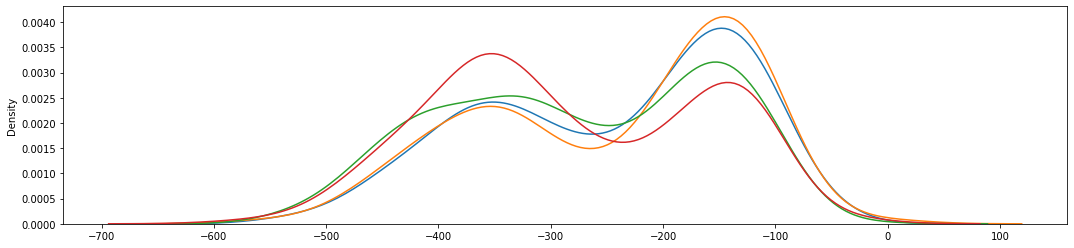

In [21]:
plt.figure(figsize=(18,4))
distplot(returns_00, hist=False, label='Action 0, first run')
distplot(returns_01, hist=False, label='Action 0, second run')
distplot(returns_10, hist=False, label='Action 1, first run')
distplot(returns_11, hist=False, label='Action 1, second run')

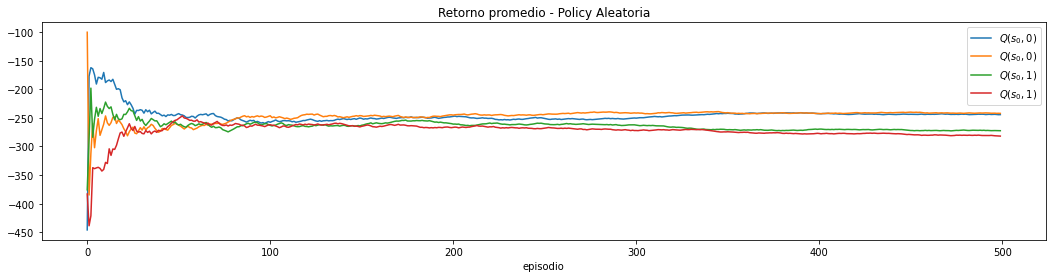

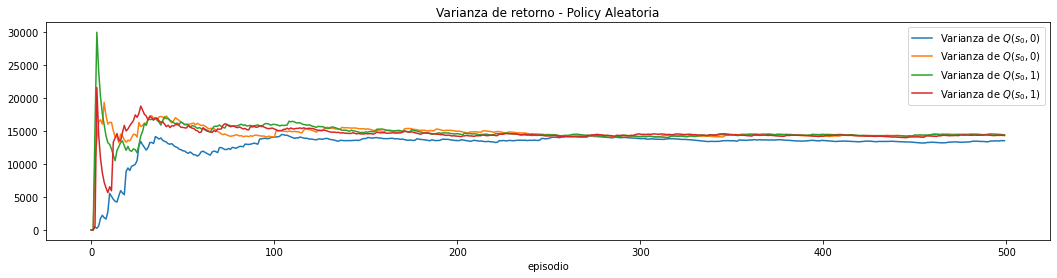

In [22]:
plt.figure(figsize=(18,4))
plt.plot(run_mean_00, label='$Q(s_0, 0)$')
plt.plot(run_mean_01, label='$Q(s_0, 0)$')
plt.plot(run_mean_10, label='$Q(s_0, 1)$')
plt.plot(run_mean_11, label='$Q(s_0, 1)$')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()
plt.figure(figsize=(18,4))
plt.plot(run_var_00, label='Varianza de $Q(s_0, 0)$')
plt.plot(run_var_01, label='Varianza de $Q(s_0, 0)$')
plt.plot(run_var_10, label='Varianza de $Q(s_0, 1)$')
plt.plot(run_var_11, label='Varianza de $Q(s_0, 1)$')
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()

Notar que dependiendo de la acción tomada, cambia levente la esperanza del retorno dado la acción, es decir la Q

# Red neuronal como policy
Armar una red neuronal con entrada igual a la dimensión del espacio de observación y salida igual a la dimensión del espacio de acción.

Con una sola capa oculta y función de activación relu en la misma

¿Cual es la función de activación a la salida?

In [23]:
def get_policy(env, hidden_layer_neurons = 128):
    output_shape = env.action_space.n
    input_shape = env.observation_space.shape
    model = Sequential()
    model.add(Dense(hidden_layer_neurons, input_shape=input_shape, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

In [24]:
model = get_policy(env_cp)
model.summary()
print(f'La dimensión de entrada de la red es {model.input.shape}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 898
Trainable params: 898
Non-trainable params: 0
_________________________________________________________________
La dimensión de entrada de la red es (None, 4)


In [55]:
def run_episode(env, model, seed=42, explore=True):
    done = False
    if seed>0:
        env.seed(seed)
    obs = env.reset()
    rewards = []
    observations = []
    actions = []
    while not done:
        actions_dist = model.predict(obs.reshape(-1, env.observation_space.shape[0]),  verbose=1)
        if explore:
            sampled_action = np.random.choice(range(env.action_space.n), p=actions_dist[0])
        else:
            sampled_action = np.argmax(actions_dist[0])
        obs_, reward, done, _ = env.step(sampled_action)
        rewards.append(reward)
        observations.append(obs)
        actions.append(sampled_action)
        obs = obs_
    return observations, actions, rewards

In [50]:
def monte_carlo(env, model, seed=42, N=500, explore=True, k=20):
  returns = []
  running_variance = RunningVariance()
  run_var = []
  run_mean = []
  for i in range(N):
    print(f'\rEpisodio: {i}', end='')
    observations, actions, rewards = run_episode(env, model, seed=seed, explore=explore)
    return_ = np.sum(rewards)
    running_variance.add(return_)
    run_var.append(running_variance.get_variance())
    run_mean.append(running_variance.get_mean())
    returns.append(return_)
  print()
  returns = np.array(returns)
  return run_mean, run_var, returns

In [57]:
%time run_mean, run_var, returns = monte_carlo(env_cp, model, seed=42, N=2000)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
1/1 [==============================] - 0s 25ms/step

CPU times: user 1h 4min 8s, sys: 2min 44s, total: 1h 6min 52s
Wall time: 1h 22min 11s


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


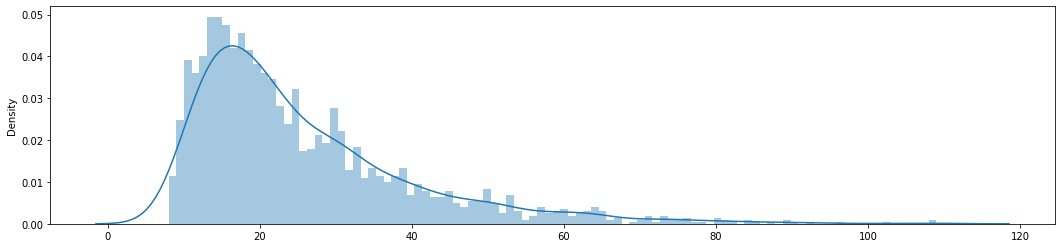

In [58]:
# Notar que es muy similar a la random policy
plt.figure(figsize=(18,4))
distplot(returns, bins=100)

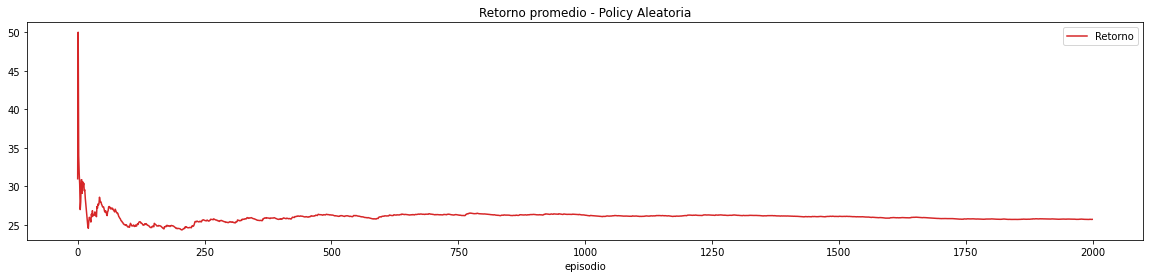

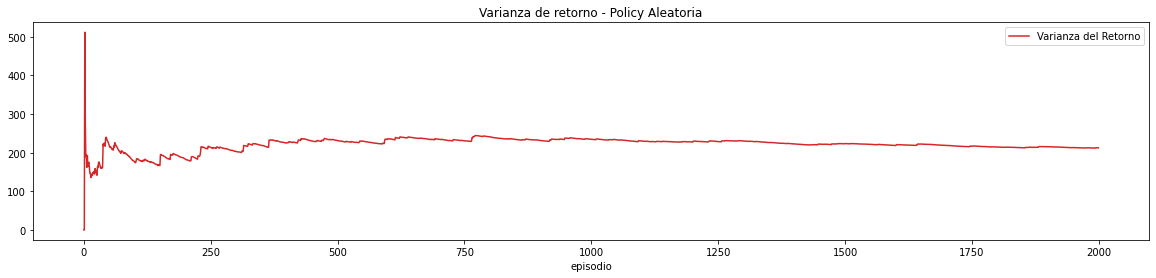

In [59]:
plt.figure(figsize=(20,4))
plt.plot(run_mean, c='C3', label='Retorno')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()
plt.figure(figsize=(20,4))
plt.plot(run_var, c='C3', label='Varianza del Retorno')
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.legend()
plt.show()

# Modelo entrenado
Notar como los modelos entrenados tienen mayor reward promedio

In [60]:
from keras.models import load_model

In [62]:
trained_model = load_model('/content/cartpole-trained.hdf5', compile=False)
#trained_model = load_model('/content/lunar-lander-trained.hdf5', compile=False)

In [63]:
# Puede tardar mas de 2 mins
%time run_mean_trained_explore, run_var_trained_explore, returns_trained_explore = monte_carlo(env_cp, trained_model, seed=42, N=100, explore=True)
%time run_mean_trained, run_var_trained, returns_trained = monte_carlo(env_cp, trained_model, seed=42, N=100, explore=False)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
1/1 [==============================] - 0s 57ms/step

CPU times: user 33min 38s, sys: 1min 26s, total: 35min 4s
Wall time: 43min 59s


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


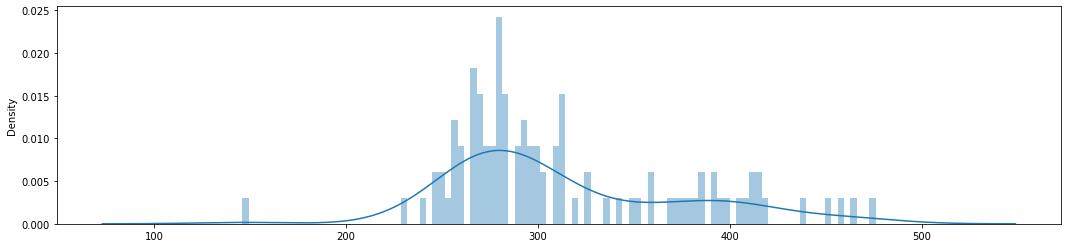

In [64]:
# Notar como cambia la distribución de regards
plt.figure(figsize=(18,4))
distplot(returns_trained_explore, bins=100, label='explore')

In [65]:
returns_trained

array([277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277., 277., 277., 277., 277., 277., 277., 277., 277., 277., 277.,
       277.])

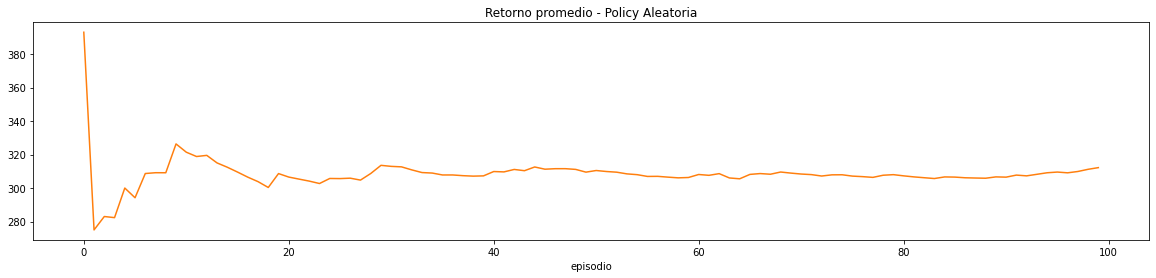

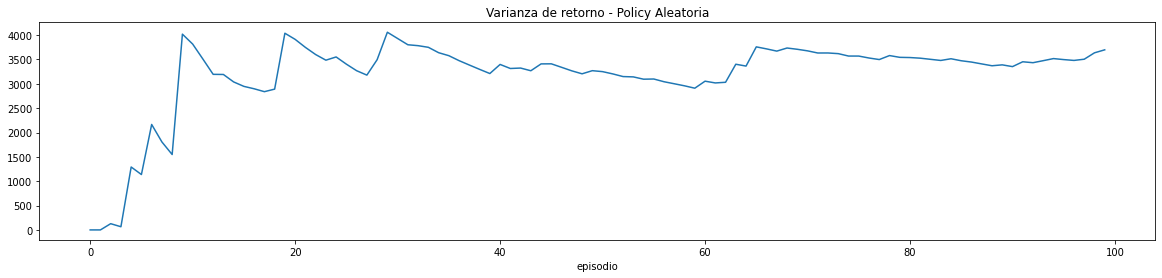

In [66]:
plt.figure(figsize=(20,4))
# plt.scatter(range(len(returns_trained[:N])), returns_trained[:N], c='C0')
plt.plot(run_mean_trained_explore, c='C1')
plt.title('Retorno promedio - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()
plt.figure(figsize=(20,4))
plt.plot(run_var_trained_explore)
plt.title('Varianza de retorno - Policy Aleatoria')
plt.xlabel('episodio')
plt.show()